# Working Across Spatial Resolutions

ERA5-Land provides hourly high resolution information of surface variables. The data is a replay of the land component of the ERA5 climate reanalysis with a finer spatial resolution: ~9km grid spacing. 

For the needs of the heat study ERA5-Land can be a very useful model. Where the higher spatial resoluiton should be better suited to capturing an urban heat island 

In [1]:
import intake
from pathlib import Path
import xarray as xr
import dask

In [2]:
catalog = intake.open_catalog(Path(Path.home(),'heat_center/data/climate/reanalysis/intake/reanalysis.yaml'))

While ERA5-Land built on top of ERA5 So should exhibit many of the same characteristics and biases. We will compare the two here to domenstrate methods to analyse data with different spatial resolutions

In [3]:
list(catalog)

['ERA5', 'ERA5-Land', 'ERA5-HEAT', 'Zhang_and_Zhou']

The following variables are available in both ERA5 and ERA5-Land:

In [4]:
list(set(list(catalog['ERA5']['day'])) & set(list(catalog['ERA5-Land']['day'])))

['ps', 'tas', 'vas', 'tasdp', 'pr', 'tasmin', 'uas', 'tasmax']

Let's start by having a look at the maximum daily temperature

In [5]:
ds = catalog['ERA5']['day']['tasmax'].to_dask().sel(time = slice('2000-01-01', '2020-12-31'))
ds_land = catalog['ERA5-Land']['day']['tasmax'].to_dask().sel(time = slice('2000-01-01', '2020-12-31'))

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


Initialy let's limit this spatialy to JHB municap region. A shape file is available at `heat_center/data/gis/RP2/JHB/openAFRICA/` We will use [geopandas](https://geopandas.org/en/stable/)

In [6]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [7]:
shpfile = gpd.read_file(Path(Path.home(),'heat_center/data/gis/RP2/JHB/vector/openAFRICA/JHB/metropolitan municipality jhb.shp'))

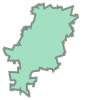

In [8]:
shpfile.iloc[0].geometry

To reduce the amount of data we are working with we will trim it spatialy to the extent of the JHB municipality

In [9]:
lonmin,latmin,lonmax,latmax = shpfile.iloc[0].geometry.bounds

In [10]:
shpfile.iloc[0].geometry.bounds

(27.714269999000066,
 -26.52629000199994,
 28.21446000000003,
 -25.902829999999938)

Roughly for now:

In [11]:
ds = ds.sel(latitude = slice(-25, -27), longitude = slice(27, 29))
ds_land = ds_land.sel(latitude = slice(-25, -27), longitude = slice(27, 29))

Now that we have trimmed the data across time and space we are left with two dataset of roughly 13 MB, so loading this into memory makes sense. This will speed things up going forwards.

In [12]:
ds_land.nbytes/1e6 #MB

13.715916

In [13]:
ds = ds.load()
ds_land = ds_land.load()

Convert from Kelvin

In [14]:
ds['tasmax'] = ds['tasmax'] - 273.15
ds_land['tasmax'] = ds_land['tasmax'] - 273.15

Let's plot the data to have a look at what we are working with 

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import seaborn as sns # for colormaps

polygon = shpfile[shpfile['OBJECTID'] == 68]

The increased resolution of ERA5-Land is clear to see. However even the higher resolution ERA5-land native resolution is 0.1 degrees of latitude and longitude. Thus at the latitude of Johannesburg each grid cell represents approximately 110 square kilometers. It is important to keep this in mind when condicting analysis. 

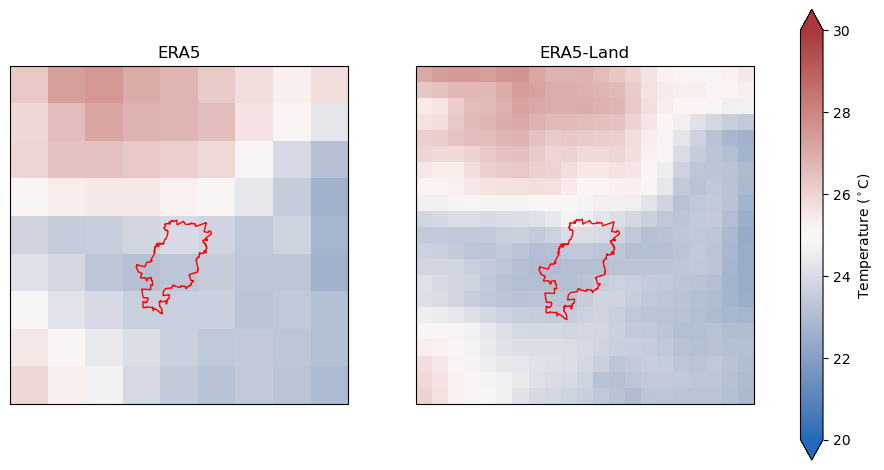

In [16]:
datasets = [ds, ds_land]
datasets_names =  ['ERA5', 'ERA5-Land']

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    p = datasets[i].tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), cmap = 'vlag', vmin = 20, vmax = 30, ax = ax, add_colorbar=False)
    ax.coastlines('10m', color='r')
    polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    ax.title.set_text(datasets_names[i])
    cbars.append(p)
    
fig.colorbar(cbars[0], ax=axes.ravel().tolist(), label = 'Temperature ($^\circ$C)', shrink = 0.65, extend = 'both')

It can be difficult to compare these two datasets empirically as the spatial resolution differ. 

One simple solution is to aggregate the data to a common resolution

Either coarsen ERA5-Land to a 0.25 degree resolution:

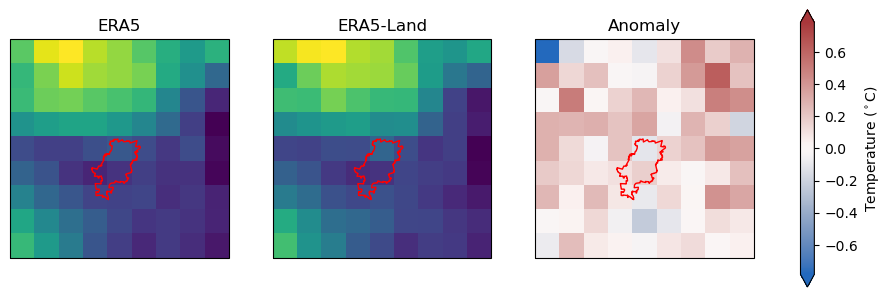

In [17]:
ds_land_coarsen = ds_land.interp(latitude = ds.latitude.values, longitude = ds.longitude.values, method = 'linear')

datasets = [ds, ds_land_coarsen, ds - ds_land_coarsen]
datasets_names =  ['ERA5', 'ERA5-Land', 'Anomaly']

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    if i == 2:
        p = datasets[i].tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax,  cmap = 'vlag', add_colorbar=False)
    else:
        p = datasets[i].tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax, add_colorbar=False)
    ax.coastlines('10m', color='r')
    polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    ax.title.set_text(datasets_names[i])
    cbars.append(p)
    
fig.colorbar(cbars[2], ax=axes.ravel().tolist(), label = 'Temperature ($^\circ$C)', shrink = 0.4, extend = 'both')

Or rather upscale ERA5 to the same resolution as ERA5-Land:

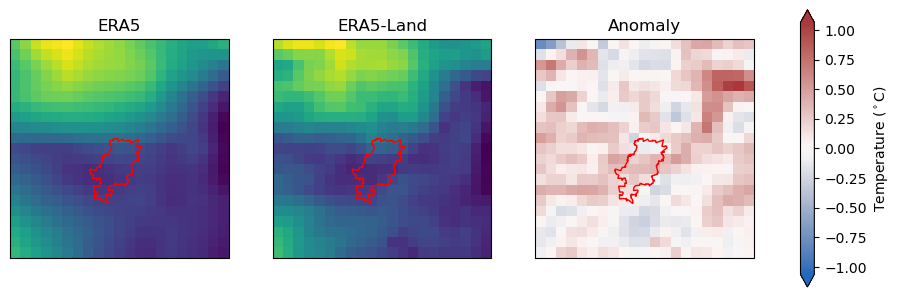

In [18]:
ds_upscale = ds.interp(latitude = ds_land.latitude.values, longitude = ds_land.longitude.values, method = 'linear')

datasets = [ds_upscale, ds_land, ds_upscale - ds_land]
datasets_names =  ['ERA5', 'ERA5-Land', 'Anomaly']

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    if i == 2:
        p = datasets[i].tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax,  cmap = 'vlag', add_colorbar=False)
    else:
        p = datasets[i].tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax, add_colorbar=False)
    ax.coastlines('10m', color='r')
    polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    ax.title.set_text(datasets_names[i])
    cbars.append(p)
    
fig.colorbar(cbars[2], ax=axes.ravel().tolist(), label = 'Temperature ($^\circ$C)', shrink = 0.4, extend = 'both')

Less than a degree difference between the two. And if we consider the maximum recorded temperature at each grid cell across a 20 year period?

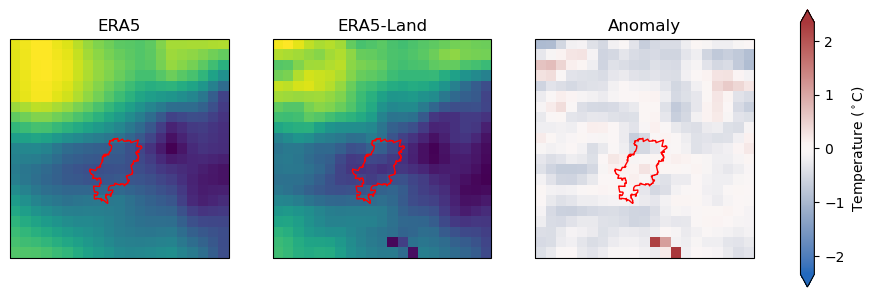

In [19]:
ds_upscale_max = ds_upscale.max(dim = 'time')
ds_land_max = ds_land.max(dim = 'time')

datasets = [ds_upscale_max, ds_land_max, ds_upscale_max - ds_land_max]
datasets_names =  ['ERA5', 'ERA5-Land', 'Anomaly']

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    if i == 2:
        p = datasets[i].tasmax.plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax,  cmap = 'vlag', add_colorbar=False)
    else:
        p = datasets[i].tasmax.plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax, add_colorbar=False)
    ax.coastlines('10m', color='r')
    polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    ax.title.set_text(datasets_names[i])
    cbars.append(p)
    
fig.colorbar(cbars[2], ax=axes.ravel().tolist(), label = 'Temperature ($^\circ$C)', shrink = 0.4, extend = 'both')

For the sake of a cool plot we can also resample to any resolution: 

<GeoAxesSubplot: title={'center': 'time = 2000-01-01T11:30:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

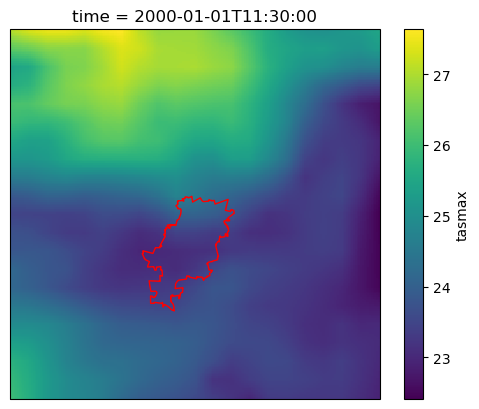

In [20]:
import numpy as np

ds_ = ds_land.interp(latitude = np.linspace(ds.latitude.values[0],ds.latitude.values[-1],210), longitude = np.linspace(ds.longitude.values[0],ds.longitude.values[-1],210))

ax = plt.subplot(projection=ccrs.PlateCarree())
ds_.tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax)
ax.coastlines('10m', color='r')
polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1)

A better choice for these two datasets may be to aggregate up to the municipal level:

In [21]:
polygon_geometary = polygon.geometry[:].unary_union

ds = ds.rio.write_crs("EPSG:4326")
ds = ds.drop_dims('bnds')
ds_clipbox = ds.rio.clip_box(*polygon.total_bounds)
ds_clip = ds_clipbox.rio.clip(polygon.geometry, all_touched = True)
ds = ds_clip

In [22]:
ds_land = ds_land.rio.write_crs("EPSG:4326")
ds_land = ds_land.drop_dims('bnds')
ds_clipbox = ds_land.rio.clip_box(*polygon.total_bounds)
ds_clip = ds_clipbox.rio.clip(polygon.geometry, all_touched = True)
ds_land = ds_clip

<GeoAxesSubplot: title={'center': 'time = 2000-01-01T11:30:00, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

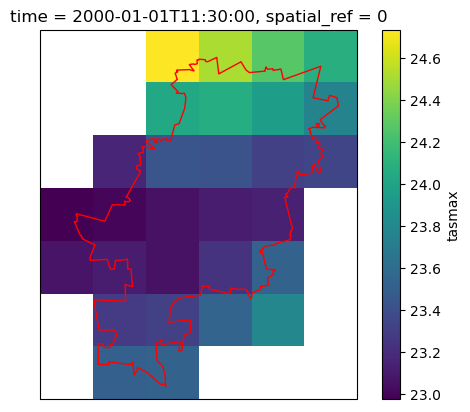

In [23]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ds_land.tasmax[0].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax)
ax.coastlines('10m', color='r')
polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1)

We can now consider the mean maximum temperature across the JHB municipal region as a timeseries:

In [24]:
import hvplot.xarray

In [25]:
ds_land.max(dim = ['latitude', 'longitude']).tasmax.resample(time = 'M').max().hvplot(label = 'ERA5-Land') * ds.max(dim = ['latitude', 'longitude']).tasmax.resample(time = 'M').max().hvplot(label = 'ERA5')

:Overlay
   .Curve.ERA5_hyphen_minus_Land :Curve   [time]   (tasmax)
   .Curve.ERA5                   :Curve   [time]   (tasmax)

Let's get back to looking at the spatial domain!

In the paper 'Urban heat in Johannesburg and Ekurhuleni, South Africa: A meter-scale assessment and vulnerability analysis' [Souverijns et al 2022](https://www.sciencedirect.com/science/article/pii/S2212095522002498) use a dynamical model to statiscally downscale ERA5 over the JHB metropolitan area. 

They make some of their data/plots available on figshare, which I have downloaded to '/heat_center/data/climate/Souverijns_et_al_2022/' Let's see how these compare to normal ERA5 and ERA5-Land

In [26]:
import fsspec
fs = fsspec.filesystem("")

In [27]:
fs.ls(Path(Path.home(),'heat_center/data/climate/Souverijns_et_al_2022/tif_files/'))

['/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_dayover30_2021_2040_rcp45.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/TX_min_2021_2040_rcp85.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_daily_mean_max_2021_2040_rcp85.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_daily_mean_max_2021_2040_rcp45.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_dayover30_duetourban_2041_2060_rcp45.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_max_2021_2040_rcp85.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_dayover30_duetourban_2041_2060_rcp85.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/Heatwave_days_2021_2040_rcp45.tif',
 '/home/pmarsh/heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_min_2001_2020.tif',
 '/home/pmarsh/heat_c

Let's consider T2M_dayover25 or the number of days that exceed 25 degrees celsius:

In [28]:
import rioxarray

da_souverijns = rioxarray.open_rasterio(Path(Path.home(),'heat_center/data/climate/Souverijns_et_al_2022/tif_files/T2M_dayover25_2001_2020.tif'), masked=True).squeeze()

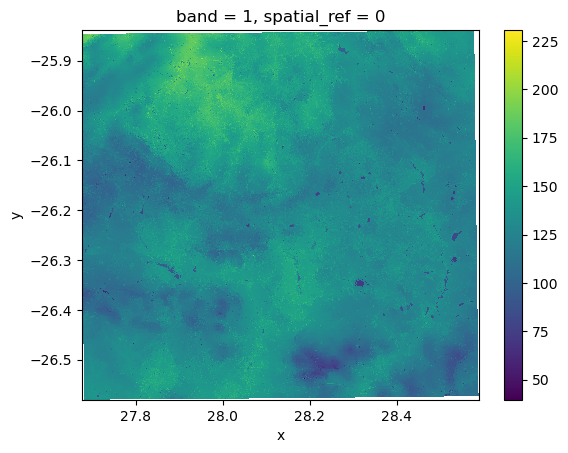

In [29]:
da_souverijns.plot()

In [30]:
polygon_geometary = polygon.geometry[:].unary_union

da_souverijns_clipbox = da_souverijns.rio.clip_box(*polygon.total_bounds)
da_souverijns_clip = da_souverijns_clipbox.rio.clip(polygon.geometry, all_touched = True)
da_souverijns = da_souverijns_clip

<GeoAxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

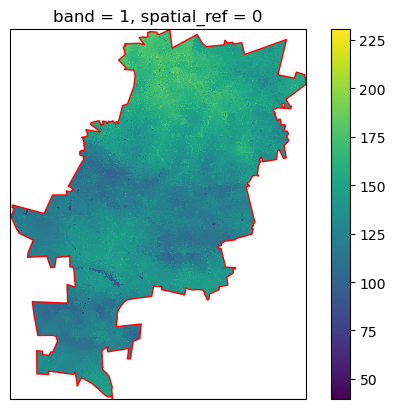

In [31]:
ax = plt.subplot(projection=ccrs.PlateCarree())
da_souverijns.plot(x='x', y='y', transform=ccrs.PlateCarree(), ax = ax)
ax.coastlines('10m', color='r')
polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1)

pretty cool, let's recreate in ERA5 and compare:

In [32]:
ds = catalog['ERA5']['day']['tas'].to_dask().sel(time = slice('2001-01-01', '2020-12-31'))
ds = ds.sel(latitude = slice(-25, -27), longitude = slice(27, 29)) #rough trim
ds['tas'] = ds['tas'] - 273.15 # convert from kelvin

let's upscale ERA5 so the visualizations compare:

In [33]:
ds = ds.load()
new_lon = np.linspace(float(ds.longitude[0]), float(ds.longitude[-1]), 100)
new_lat = np.linspace(float(ds.latitude[0]), float(ds.latitude[-1]), 100)
ds_upscale = ds.interp(latitude = new_lat, longitude = new_lon, method = 'linear')

Now let's calculate the number of days that exceed 30 degrees celsius

In [34]:
ds_upscale = ds_upscale.tas >= 25
ds_upscale = (ds_upscale/ds_upscale).sum(dim = 'time', skipna = True)

<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

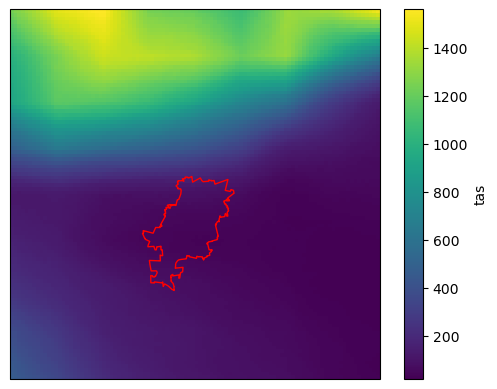

In [35]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ds_upscale.plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), ax = ax)
ax.coastlines('10m', color='r')
polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1)

In [36]:
polygon_geometary = polygon.geometry[:].unary_union

ds_upscale = ds_upscale.rio.write_crs("EPSG:4326")
ds_upscale_clipbox = ds_upscale.rio.clip_box(*polygon.total_bounds)
ds_upscale_clip = ds_upscale_clipbox.rio.clip(polygon.geometry, all_touched = True)

Let's also include ERA5-Land

In [37]:
ds_land = catalog['ERA5-Land']['day']['tas'].to_dask().sel(time = slice('2001-01-01', '2020-12-31'))
ds_land = ds_land.sel(latitude = slice(-25, -27), longitude = slice(27, 29)) #rough trim
ds_land['tas'] = ds_land['tas'] - 273.15 # convert from kelvin

In [38]:
ds_land = ds_land.load()
new_lon = np.linspace(float(ds_land.longitude[0]), float(ds_land.longitude[-1]), 100)
new_lat = np.linspace(float(ds_land.latitude[0]), float(ds_land.latitude[-1]), 100)
ds_land = ds_land.interp(latitude = new_lat, longitude = new_lon, method = 'linear')

In [39]:
ds_land = ds_land.tas >= 25
ds_land = (ds_land/ds_land).sum(dim = 'time', skipna = True)

In [40]:
ds_land = ds_land.rio.write_crs("EPSG:4326")
ds_clipbox = ds_land.rio.clip_box(*polygon.total_bounds)
ds_clip = ds_clipbox.rio.clip(polygon.geometry, all_touched = True)
ds_land = ds_clip

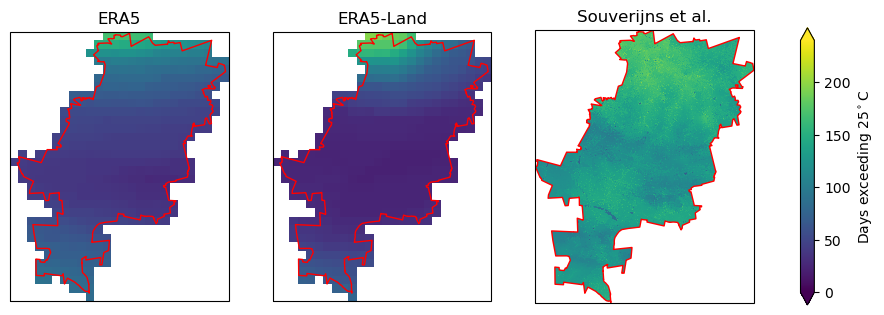

In [41]:
datasets = [ds_upscale_clip, ds_land, da_souverijns]
datasets_names =  ['ERA5', 'ERA5-Land','Souverijns et al.']

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    p = datasets[i].plot(transform=ccrs.PlateCarree(), ax = ax, add_colorbar=False, vmin = 0, vmax = 240)
    ax.coastlines('10m', color='r')
    polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    ax.title.set_text(datasets_names[i])
    cbars.append(p)
    
fig.colorbar(cbars[1], ax=axes.ravel().tolist(), label = 'Days exceeding 25$^\circ$C', shrink = 0.4, extend = 'both')

Let's add the finer ward level boundaries:

In [42]:
admin_shpfile = gpd.read_file(Path(Path.home(),'heat_center/data/gis/RP2/JHB/vector/zaf_adm_sadb_ocha_20201109_SHP/zaf_admbnda_adm4_sadb_ocha_20201109.shp'))
admin_shpfile = admin_shpfile[admin_shpfile.ADM2_EN == 'City of Johannesburg']

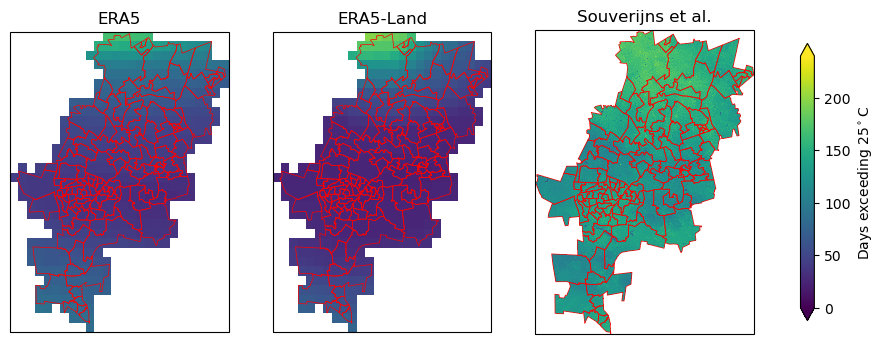

In [43]:
datasets = [ds_upscale_clip, ds_land, da_souverijns]
datasets_names =  ['ERA5', 'ERA5-Land','Souverijns et al.']

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    p = datasets[i].plot(transform=ccrs.PlateCarree(), ax = ax, add_colorbar=False, vmin = 0, vmax = 240)
    ax.coastlines('10m', color='r')
    #polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    admin_shpfile.plot(ax= ax, facecolor="none", edgecolor="red", lw = 0.5)
    ax.title.set_text(datasets_names[i])
    cbars.append(p)
    
fig.colorbar(cbars[1], ax=axes.ravel().tolist(), label = 'Days exceeding 25$^\circ$C', shrink = 0.4, extend = 'both')

## Zhang and Zhou 2022
Zhang and Zhou 2022 created a global 1km daily air temperature dataset. 

In [65]:
catalog['Zhang_and_Zhou']['Tmax'].to_dask()

<xarray.Dataset>
Dimensions:  (time: 1155, lat: 7855, lon: 9923)
Coordinates:
  * lat      (lat) float64 38.0 37.99 37.98 37.98 ... -35.72 -35.73 -35.74
  * lon      (lon) float64 -23.89 -23.88 -23.87 -23.86 ... 69.26 69.27 69.28
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2006-03-01T12:00:00
Data variables:
    Tmax     (time, lat, lon) float64 dask.array<chunksize=(30, 200, 200), meta=np.ndarray>

In [45]:
ds = catalog['Zhang_and_Zhou']['Tmax'].to_dask().sel(time = slice('2003-01-01', '2020-12-31'))
ds = ds.sel(lat = slice(-25, -27), lon = slice(27, 29)) #rough trim
ds = ds['Tmax'] - 273.15 # convert from kelvin
ds = ds.where(ds > 0)    # seems to be some quirks in the data ?!
ds = ds.mean(dim = 'time', skipna = True)
ds = ds.load()

ds = ds.rio.write_crs("EPSG:4326")
ds_clipbox = ds.rio.clip_box(*polygon.total_bounds)
ds_clip = ds_clipbox.rio.clip(polygon.geometry, all_touched = True)
ds = ds_clip

In [46]:
ds_land = catalog['ERA5-Land']['day']['tasmax'].to_dask().sel(time = slice('2003-01-01', '2020-12-31'))
ds_land = ds_land.sel(latitude = slice(-25, -27), longitude = slice(27, 29)) #rough trim
ds_land = ds_land['tasmax'] - 273.15 # convert from kelvin
ds_land = ds_land.mean(dim = 'time', skipna = True)
ds_land = ds_land.load()


ds_land = ds_land.rio.write_crs("EPSG:4326")
ds_clipbox = ds_land.rio.clip_box(*polygon.total_bounds)
ds_clip = ds_clipbox.rio.clip(polygon.geometry, all_touched = True)
ds_land = ds_clip

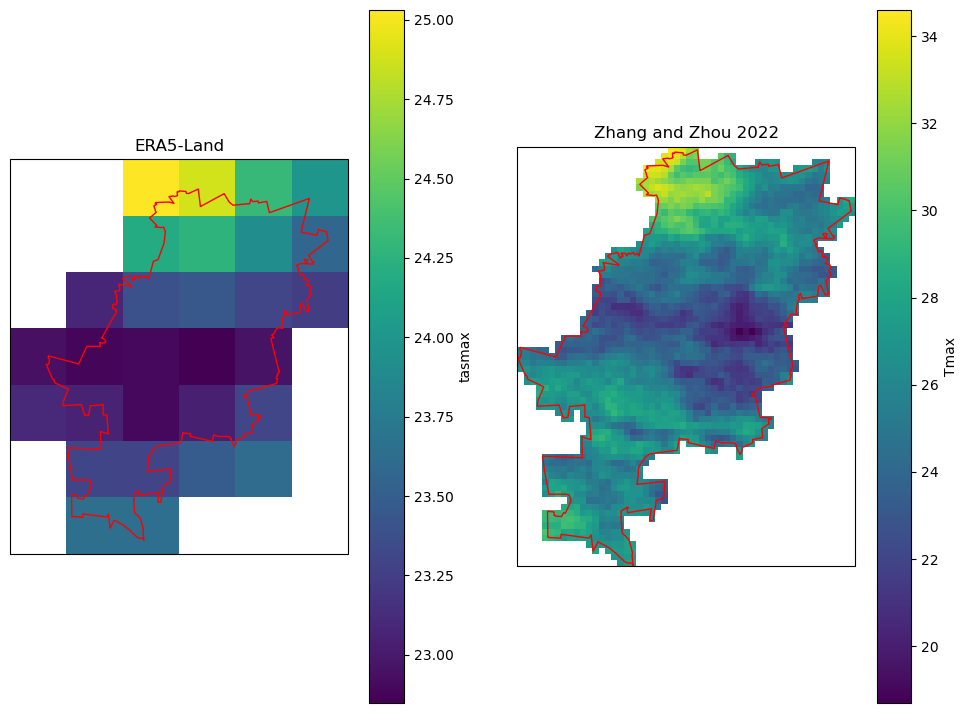

In [47]:
datasets = [ds_land, ds]
datasets_names =  ['ERA5-Land','Zhang and Zhou 2022']

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})
cbars = []

for i,ax in enumerate(axes.flatten()):
    p = datasets[i].plot(transform=ccrs.PlateCarree(), ax = ax)#, add_colorbar=False, vmin = 10, vmax = 40)
    ax.coastlines('10m', color='r')
    polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())
    ax.title.set_text(datasets_names[i])
    #cbars.append(p)
    
#fig.colorbar(cbars[1], ax=axes.ravel().tolist(), label = '2003 Mean Daily Max temperature $^\circ$C', shrink = 0.4, extend = 'both')

In [48]:
ds = catalog['Zhang_and_Zhou']['Tmax'].to_dask().sel(time = slice('2003-01-01', '2003-12-31'))
ds = ds.sel(lat = slice(-25, -27), lon = slice(27, 29)) #rough trim
ds = ds['Tmax'] - 273.15 # convert from kelvin
#ds = ds.where(ds > 0)
#ds = ds.mean(dim = 'time', skipna = True)
ds = ds[0]
ds = ds.load()

ds = ds.rio.write_crs("EPSG:4326")
ds_clipbox = ds.rio.clip_box(*polygon.total_bounds)
ds_clip = ds_clipbox.rio.clip(polygon.geometry, all_touched = True)
ds = ds_clip

In [49]:
ds.min()

<xarray.DataArray 'Tmax' ()>
array(-3.15)
Coordinates:
    time         datetime64[ns] 2003-01-01T12:00:00
    spatial_ref  int64 0

<GeoAxesSubplot: title={'center': 'Zhang and Zhou 2022'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

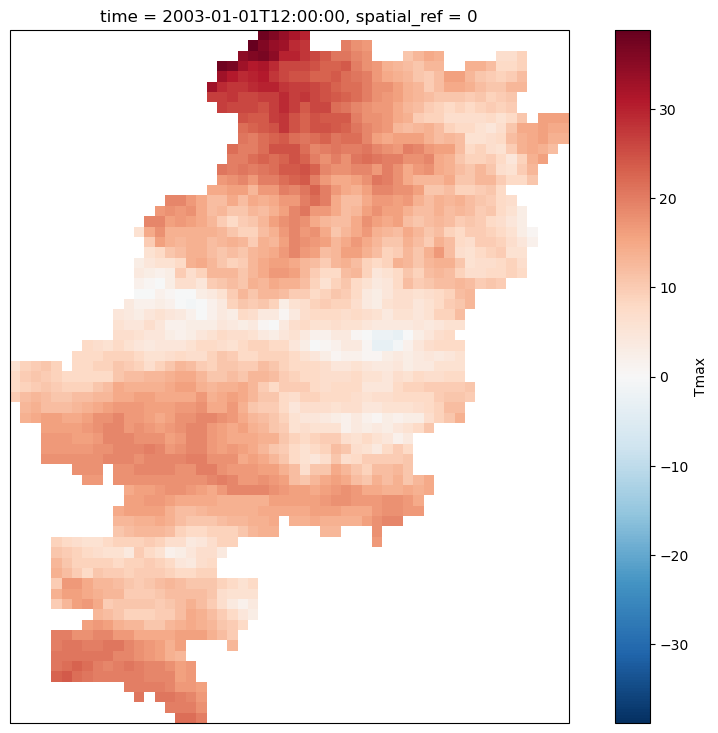

In [50]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})

ds.plot(transform=ccrs.PlateCarree(), ax = axes)#, add_colorbar=False, vmin = 10, vmax = 40)
ax.coastlines('10m', color='r')
polygon.plot(ax = ax, facecolor="none", edgecolor="red", lw = 1, transform=ccrs.PlateCarree())

In [51]:
ds = catalog['Zhang_and_Zhou']['Tmax'].to_dask().sel(time = slice('2003-01-01', '2003-01-31'))
ds = ds.sel(lat=slice(-25, -35), lon=slice(12, 35))
ds = ds['Tmax'] - 273.15 # convert from kelvin
ds = ds.mean(dim = 'time', skipna = True)
ds = ds.load()

In [52]:
ds

<xarray.DataArray 'Tmax' (lat: 1065, lon: 2450)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -25.0 -25.01 -25.02 -25.03 ... -34.97 -34.98 -34.99
  * lon      (lon) float64 12.0 12.01 12.02 12.03 ... 34.97 34.98 34.99 35.0

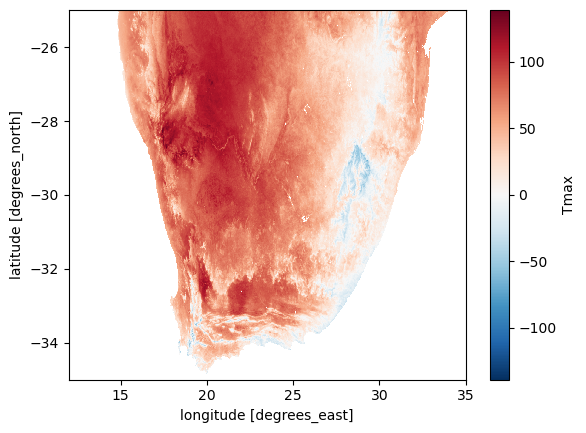

In [53]:
ds.plot()

In [54]:
import pandas as pd

In [55]:
year = 2003 
files = fs.glob(Path(Path.home(),f'heat_center/data/climate/Zhang_and_Zhou_2022/Africa{year}/*TMAX*'))
file_chunks = [files[i:i+20] for i in range(0, len(files), 20)]

In [56]:
file = file_chunks[0][0]

In [57]:
ds = rioxarray.open_rasterio(file)
ds = ds.isel(band = 0)
ds = ds.rio.reproject("EPSG:4326")
ds = ds.rename({'x':'lon', 'y':'lat'})
ds = ds.drop('band')
ds = ds.drop('spatial_ref')
doy = int(file.split('_')[-1].split('.')[0])
date = pd.Timestamp(year=year, month=1, day=1, hour = 12) + pd.Timedelta(days=doy - 1)
ds = ds.assign_coords(time = date)
ds = ds.expand_dims(dim="time")

In [58]:
ds = ds.where(ds != ds.attrs['_FillValue'])

(array([4.000000e+01, 4.712000e+03, 8.693800e+04, 6.500410e+05,
        3.652794e+06, 5.317706e+06, 8.972024e+06, 7.746504e+06,
        2.142639e+06, 1.805610e+05]),
 array([  8. ,  51.1,  94.2, 137.3, 180.4, 223.5, 266.6, 309.7, 352.8,
        395.9, 439. ]),
 <BarContainer object of 10 artists>)

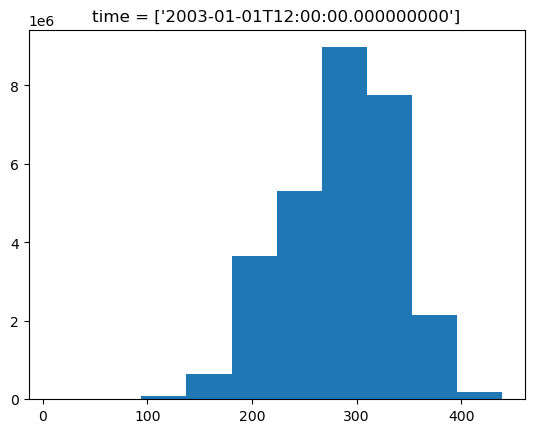

In [59]:
ds.plot.hist()

In [60]:
ds.min() - 273.15

<xarray.DataArray ()>
array(-265.15)

In [61]:
ds = ds.isel(time = 0)

In [62]:
ds = ds.sel(lat=slice(-25, -35), lon=slice(12, 35))

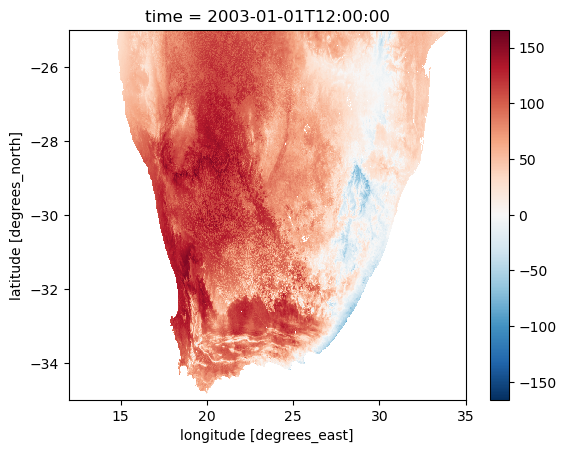

In [63]:
(ds - 273.15).plot()

In [64]:
    for file_chunk in file_chunks:
        datasets = []
        for file in file_chunk:
            ds = rioxarray.open_rasterio(file)
            ds = ds.isel(band = 0)
            ds = ds.rio.reproject("EPSG:4326")
            ds = ds.rename({'x':'lon', 'y':'lat'})
            ds = ds.drop('band')
            ds = ds.drop('spatial_ref')
            doy = int(file.split('_')[-1].split('.')[0])
            date = pd.Timestamp(year=year, month=1, day=1, hour = 12) + pd.Timedelta(days=doy - 1)
            ds = ds.assign_coords(time = date)
            ds = ds.expand_dims(dim="time")
            ds = ds.where(ds != ds.attrs['_FillValue'])